<a href="https://colab.research.google.com/github/thefr33radical/hybrid_forecasting/blob/master/code/ARIMA_ANN_lynx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install statsmodels
import pandas as pd 
import numpy as np
from google.colab import files
import io
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score,mean_squared_error as ms
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA

data = files.upload()
data = pd.read_csv(io.BytesIO(data["lynx.csv"]),index_col=0)
data = data.set_index("time")
print(data)


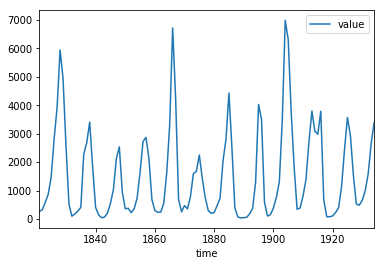

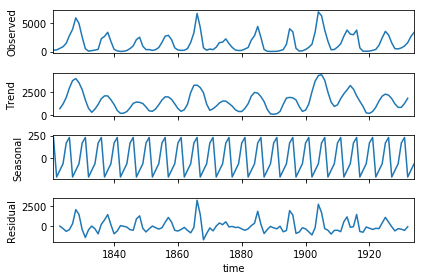

In [77]:
data.plot()
plt.show()
ndata= seasonal_decompose(data,model="additive",freq=5)
ndata.plot()
plt.show()

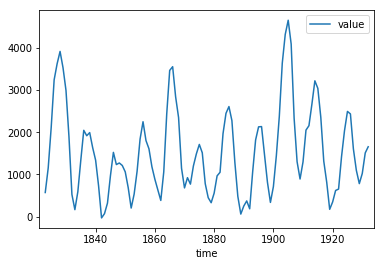

In [83]:
linear_data = ndata.trend+ ndata.seasonal 
linear_data.plot()
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


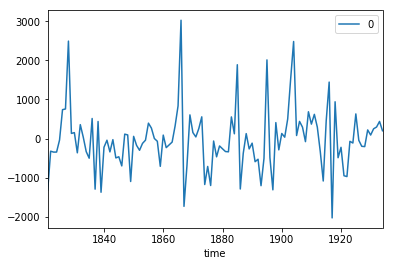

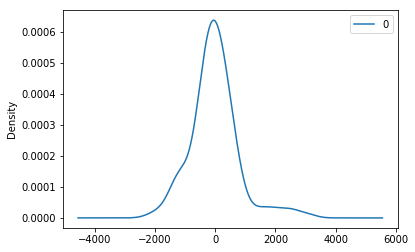

                 0
count   114.000000
mean    -23.493618
std     796.746429
min   -2032.365720
25%    -361.635927
50%     -55.125427
75%     293.412023
max    3026.929576
(array([3168.81799597]), array([780.56243615]), array([[1638.94373343, 4698.69225852]]))


In [86]:
# ARIMA individual

train_data =  data.iloc[:100,:]
test_data =   data.iloc[101:,:]

model_arima = ARIMA(data, order=(9,0,0))
model_fit = model_arima.fit(disp=0)
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())
model_fit.summary()

#y_train_pred = model_fit.forecast(x_train)
y_test_pred = model_fit.forecast()
print(y_test_pred)

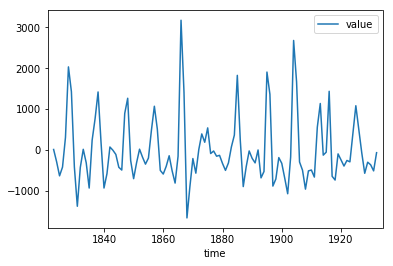

            value
time             
1821          NaN
1822          NaN
1823    13.400000
1824  -283.218182
1825  -630.263636
1826  -416.936364
1827   311.218182
1828  2031.800000
1829  1426.181818
1830  -410.463636
1831 -1373.736364
1832  -427.581818
1833    18.000000
1834  -311.618182
1835  -928.663636
1836   241.263636
1837   769.218182
1838  1419.200000
1839   188.781818
1840  -927.863636
1841  -578.736364
1842    74.418182
1843    -4.000000
1844  -107.618182
1845  -421.063636
1846  -488.736364
1847   895.418182
1848  1265.400000
1849  -254.618182
1850  -699.463636
...           ...
1905  1663.936364
1906  -292.136364
1907  -491.381818
1908  -955.400000
1909  -509.418182
1910  -488.463636
1911  -660.536364
1912   559.618182
1913  1137.200000
1914  -124.418182
1915   -52.263636
1916  1435.463636
1917  -641.381818
1918  -733.000000
1919   -94.018182
1920  -240.663636
1921  -390.936364
1922  -254.381818
1923  -288.600000
1924   397.981818
1925  1082.736364
1926   503.263636
1927   -68

In [92]:
non_linear_data = ndata.resid 
non_linear_data.plot()
plt.show()
print(non_linear_data)

In [0]:
# ANN individual

data["value+1"]=data["value"].shift(-1)

train_data =  data.iloc[2:100,:]
test_data =  data.iloc[101:-1,:]

x_train = train_data["value"]
y_train = train_data["value+1"]

x_test = test_data["value"]
y_test = test_data["value+1"]


model = Sequential()
model.add(Dense(7,input_dim=1,activation="relu"))
model.add(Dense(5))
model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="Adam")
early_stop = EarlyStopping(monitor ="loss",patience =10, verbose =1)
model.fit(x_train,y_train, epochs =25, callbacks=[early_stop], batch_size=10,verbose=1,shuffle= False)

y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

print("The MSE score on the Train set is:\t{:0.3f}".format(ms(y_train, y_train_pred)))
print("The MSE score on the Test set is:\t{:0.3f}".format(ms(y_test, y_test_pred)))
#print(y_test, y_test_pred,y_train,y_train_pred)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


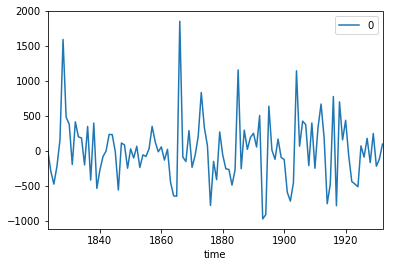

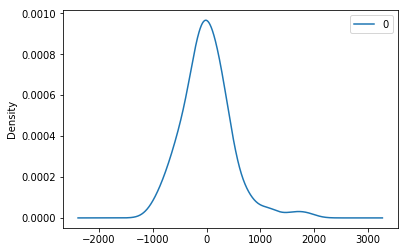

                 0
count   110.000000
mean      9.342287
std     462.550895
min    -973.479213
25%    -248.619505
50%      -6.354771
75%     234.500198
max    1853.870263
(array([396.37318701]), array([445.93376419]), array([[-477.64093029, 1270.38730431]]))


In [94]:
# ARIMA Hybrid


model_arima = ARIMA(non_linear_data[2:-2], order=(9,0,0))
model_fit = model_arima.fit(disp=0)
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
plt.show()

print(residuals.describe())
model_fit.summary()
y_test_pred = model_fit.forecast()
print(y_test_pred)

In [95]:
# ANN Hybrid

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score,mean_squared_error as ms
from sklearn.preprocessing import MinMaxScaler

train_data =  non_linear_data.iloc[2:100,:]
test_data =  non_linear_data.iloc[101:-2,:]

#print(train_data,test_data)
x_train = train_data[:-1]
y_train = train_data[1:]

x_test = test_data[:-1]
y_test = test_data[1:]

model = Sequential()
model.add(Dense(7,input_dim=1,activation="relu"))
model.add(Dense(5))
model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="Adam")
early_stop = EarlyStopping(monitor ="loss",patience =2, verbose =1)
model.fit(x_train,y_train, epochs =50, callbacks=[early_stop],batch_size=2,verbose=1,shuffle= False)

y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

print("The MSE score on the Train set is:\t{:0.3f}".format(ms(y_train, y_train_pred)))
print("The MSE score on the Test set is:", ms( y_test_pred,y_test))

Epoch 1/50
97/97 [==============================] - 3s 33ms/step - loss: 676875.7215
Epoch 2/50
97/97 [==============================] - 0s 976us/step - loss: 656038.4166
Epoch 3/50
97/97 [==============================] - 0s 990us/step - loss: 646494.0979
Epoch 4/50
97/97 [==============================] - 0s 995us/step - loss: 641537.8761
Epoch 5/50
97/97 [==============================] - 0s 1ms/step - loss: 638611.2280
Epoch 6/50
97/97 [==============================] - 0s 1ms/step - loss: 636716.4706
Epoch 7/50
97/97 [==============================] - 0s 1ms/step - loss: 635434.6941
Epoch 8/50
97/97 [==============================] - 0s 973us/step - loss: 634558.8902
Epoch 9/50
97/97 [==============================] - 0s 1ms/step - loss: 633965.1571
Epoch 10/50
97/97 [==============================] - 0s 930us/step - loss: 633568.6771
Epoch 11/50
97/97 [==============================] - 0s 987us/step - loss: 633308.2836
Epoch 12/50
97/97 [==============================] - 0s 988us